In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

Input DataFrame type: <class 'pandas.core.frame.DataFrame'>
Total instances in original dataset: 690
Instances held for extrapolation: 11
Instances used for training/validation: 679

Target Statistics (final_expandEvts):
Mean (censored=0): 53227800.02
Std Dev (censored=0): 174281183.67
Selected features (18): ['avg_pruneBacktrackEvts', 'avg_expandEvts', 'max_pruneBacktrackEvts', 'max_expandEvts', 'k', 'n', 'max_to_avg_ratio', 'range_to_avg_ratio', 'expandEvts_ratio_1', 'pruneBacktrackEvts_ratio_1', 'expandEvts_ratio_2', 'pruneBacktrackEvts_ratio_2', 'expandEvts_ratio_3', 'pruneBacktrackEvts_ratio_3', 'expandEvts_ratio_4', 'pruneBacktrackEvts_ratio_4', 'expandEvts_ratio_5', 'pruneBacktrackEvts_ratio_5']

Starting GridSearchCV for 'censored' data...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

GridSearchCV finished.
Best parameters for censored model: {'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 31, 'reg_alpha': 0}
{'best_params_censored': {'learning_rate'

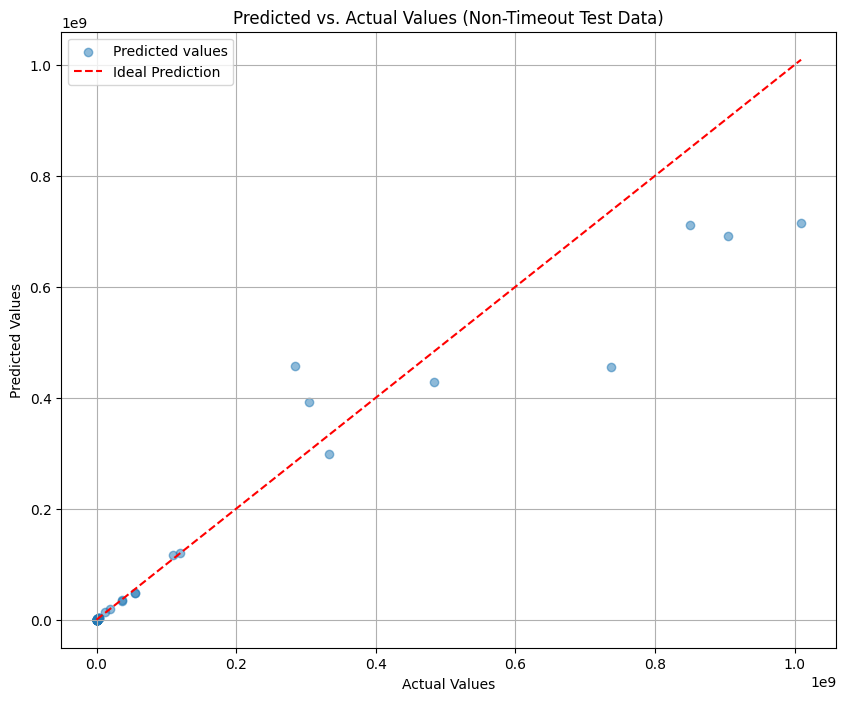

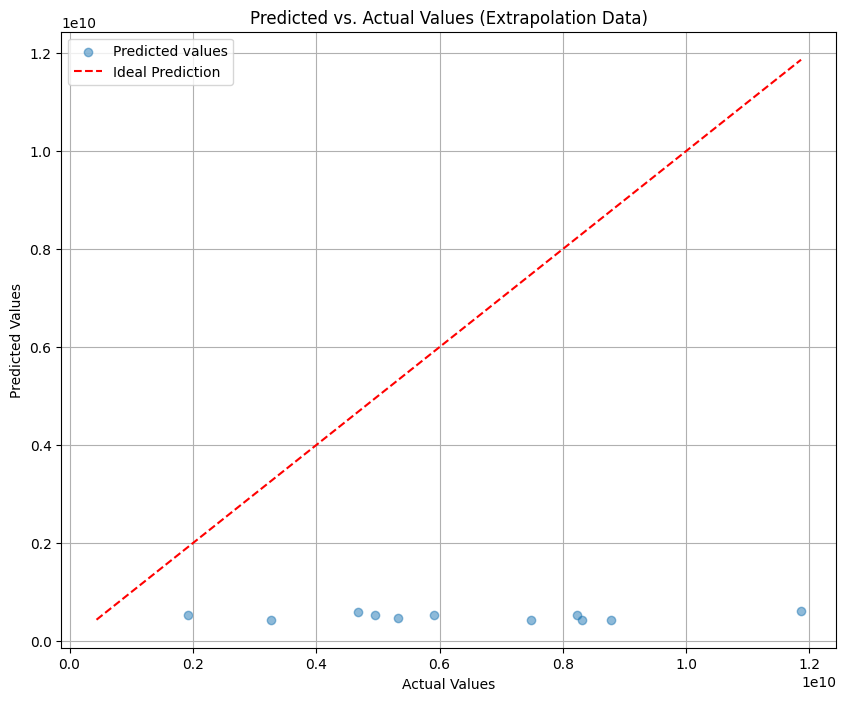

In [19]:
def calculate_metrics(y_true, y_pred):
    """
    Calculates various regression metrics including RMSE, Normalized RMSE, SMAPE, and SMDApe.
    
    Args:
        y_true (np.array): The actual target values.
        y_pred (np.array): The predicted target values.
        
    Returns:
        dict: A dictionary containing the calculated metrics.
    """
    try:
        # Avoid division by zero by adding a small epsilon to the denominator
        epsilon = 1e-10

        # Calculate Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        # Calculate Normalized Root Mean Squared Error (Normalized RMSE) as a percentage
        # using the mean of the actual values. This is a key change.
        norm_rmse = (rmse / (np.mean(y_true) + epsilon)) * 100

        # Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
        smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + epsilon)) * 100

        # Calculate Symmetric Mean Directional Absolute Percentage Error (SMDAPE)
        # This is similar to SMAPE but with a directional component
        smdape = np.mean((y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + epsilon)) * 100

        return {
            'rmse': rmse,
            'norm_rmse': norm_rmse,
            'smape': smape,
            'smdape': smdape
        }
    except Exception as e:
        print(f"Error in calculate_metrics: {e}")
        return None

def plot_predictions(y_actual, y_predicted, title):
    """
    Plots the predicted values against the actual values to visualize model performance.
    
    Args:
        y_actual (pd.Series or np.array): The actual target values.
        y_predicted (np.array): The predicted values from the model.
        title (str): The title for the plot.
    """
    plt.figure(figsize=(10, 8))
    # Create a scatter plot of actual vs predicted values
    plt.scatter(y_actual, y_predicted, alpha=0.5, label='Predicted values')
    
    # Get the min and max values for the ideal line
    min_val = min(y_actual.min(), y_predicted.min())
    max_val = max(y_actual.max(), y_predicted.max())
    
    # Plot the ideal prediction line (y=x)
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Prediction')
    
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

def train_lightgbm_model(df, include_ratios=False):
    """
    Trains a LightGBM model on the given dataset and evaluates its performance.
    
    This function now includes hyperparameter tuning using GridSearchCV to find the
    optimal parameters for the 'censored' model.
    
    Args:
        df (pd.DataFrame): The input data frame.
        include_ratios (bool): Whether to include ratio features in the training.
        
    Returns:
        dict: A dictionary of evaluation results, feature importance, and the
              best hyperparameters found by GridSearchCV.
    """
    try:
        # Validate input
        print(f"Input DataFrame type: {type(df)}")
        if not isinstance(df, pd.DataFrame) or df.empty:
            print("Input DataFrame is not valid.")
            return None
        
        # Define the extrapolation filenames based on your previous notebooks
        extrapolation_filenames = [
            'n27k3_v1.txt', 'n27k3_v2.txt', 'n27k3_v3.txt', 'n27k3_v4.txt',
            'n28k3_v1.txt', 'n28k3_v2.txt', 'n28k3_v3.txt', 'n28k3_v4.txt',
            'n28k3_v5.txt', 'n29k3_v1.txt', 'n29k3_v2.txt'
        ]

        # Separate extrapolation data based on filename
        df_extrapolation = df[df['filename'].isin(extrapolation_filenames)].copy()
        df_train_val = df[~df['filename'].isin(extrapolation_filenames)].copy()

        # Separate the censored data for a 'no timeout' model
        df_no_timeout = df_train_val[df_train_val['censored'] == 0].copy()
        
        print(f"Total instances in original dataset: {len(df)}")
        print(f"Instances held for extrapolation: {len(df_extrapolation)}")
        print(f"Instances used for training/validation: {len(df_train_val)}")
        print("\nTarget Statistics (final_expandEvts):")
        print(f"Mean (censored=0): {df_no_timeout['final_expandEvts'].mean():.2f}")
        print(f"Std Dev (censored=0): {df_no_timeout['final_expandEvts'].std():.2f}")

        # Dynamically select features based on what's available in the dataframe
        all_possible_features = [
            'avg_pruneBacktrackEvts', 'avg_expandEvts', 'median_pruneBacktrackEvts',
            'median_expandEvts', 'max_pruneBacktrackEvts', 'max_expandEvts',
            'std_dev_pruneBacktrackEvts', 'std_dev_expandEvts',
            'k', 'n', 'c_ratio', 'p_ratio', 'p_div_c_ratio', 'p_sub_c_ratio'
        ]
        
        features = [col for col in all_possible_features if col in df.columns]
        if include_ratios:
            # Add ratio features if they exist and are specified
            ratio_features = [col for col in df.columns if 'ratio' in col and col not in features]
            features.extend(ratio_features)

        print(f"Selected features ({len(features)}): {features}")
        
        target = 'final_expandEvts'

        # Separate target variable from features for all three datasets
        X_censored = df_no_timeout[features]
        y_censored = df_no_timeout[target]
        X_all = df_train_val[features]
        y_all = df_train_val[target]
        X_extrapolation = df_extrapolation[features]
        y_extrapolation = df_extrapolation[target]

        # Handle potential zero values in target to avoid log-transform issues
        y_censored = y_censored + 1
        y_all = y_all + 1
        y_extrapolation = y_extrapolation + 1
        
        # --- Start of Hyperparameter Tuning Section ---
        
        # Define the parameter grid to search over
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.05, 0.1, 0.15],
            'num_leaves': [31, 50, 70],
            'reg_alpha': [0, 0.1]
        }
        
        # Create a base LightGBM model with warnings suppressed
        lgbm = lgb.LGBMRegressor(random_state=42, verbose=-1)
        
        # Set up GridSearchCV with 5-fold cross-validation
        # We use 'neg_root_mean_squared_error' as the scoring metric.
        # The best model will have the lowest RMSE (highest negative RMSE).
        grid_search = GridSearchCV(
            estimator=lgbm,
            param_grid=param_grid,
            cv=KFold(n_splits=5, shuffle=True, random_state=42),
            scoring='neg_root_mean_squared_error',
            verbose=1,
            n_jobs=-1  # Use all available CPU cores
        )
        
        print("\nStarting GridSearchCV for 'censored' data...")
        # Fit the grid search to find the best model for the censored data
        # We are training on the log-transformed target variable
        grid_search.fit(X_censored, np.log1p(y_censored))
        
        # Get the best parameters and best model from the grid search
        best_params_censored = grid_search.best_params_
        lgbm_censored = grid_search.best_estimator_
        
        print("\nGridSearchCV finished.")
        print(f"Best parameters for censored model: {best_params_censored}")
        
        # --- End of Hyperparameter Tuning Section ---
        
        # Train a model on censored=0 (non-timeout) data using the best estimator
        X_train, X_test, y_train, y_test = train_test_split(X_censored, y_censored, test_size=0.2, random_state=42)
        # lgbm_censored is already the best estimator, so we just use it to predict on the test set
        y_pred_censored_test_log = lgbm_censored.predict(X_test)
        y_pred_censored_test = np.expm1(y_pred_censored_test_log)
        
        # Evaluate censored model on test set
        metrics_censored_test = calculate_metrics(y_test, y_pred_censored_test)
        
        # Cross-validation for censored model (this is now redundant due to GridSearchCV but kept for a full CV score)
        cv_rmse_censored = -grid_search.best_score_
        cv_norm_rmse_censored = cv_rmse_censored / np.mean(y_censored) * 100
        
        # Train a model on all data (including timeouts) - no tuning here to simplify
        lgbm_all = lgb.LGBMRegressor(random_state=42, verbose=-1)
        lgbm_all.fit(X_all, np.log1p(y_all))
        y_pred_all = np.expm1(lgbm_all.predict(X_all))
        
        # Evaluate all data model
        metrics_all = calculate_metrics(y_all, y_pred_all)
        
        # Cross-validation for all data model
        cv_scores_all = cross_val_score(lgbm_all, X_all, np.log1p(y_all), cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='neg_root_mean_squared_error')
        cv_rmse_all = -np.mean(cv_scores_all)
        cv_norm_rmse_all = cv_rmse_all / np.mean(y_all) * 100

        # Predict on extrapolation data using the tuned censored model
        y_pred_extrapolation_log = lgbm_censored.predict(X_extrapolation)
        y_pred_extrapolation = np.expm1(y_pred_extrapolation_log)
        metrics_extrapolation = calculate_metrics(y_extrapolation, y_pred_extrapolation)

        # Feature importance from the 'all data' model
        importance = pd.DataFrame({
            'feature': features,
            'importance': lgbm_all.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Store results in a dictionary
        results = {
            'best_params_censored': best_params_censored, # Store the best parameters
            'rmse_censored_test': metrics_censored_test['rmse'],
            'norm_rmse_censored_test': metrics_censored_test['norm_rmse'],
            'smape_censored_test': metrics_censored_test['smape'],
            'smdape_censored_test': metrics_censored_test['smdape'],
            'cv_norm_rmse_censored': cv_norm_rmse_censored,
            'rmse_all': metrics_all['rmse'],
            'norm_rmse_all': metrics_all['norm_rmse'],
            'smape_all': metrics_all['smape'],
            'smdape_all': metrics_all['smdape'],
            'cv_norm_rmse_all': cv_norm_rmse_all,
            'feature_importance': importance,
            'rmse_extrapolation': metrics_extrapolation['rmse'],
            'norm_rmse_extrapolation': metrics_extrapolation['norm_rmse'],
            'smape_extrapolation': metrics_extrapolation['smape'],
            'smdape_extrapolation': metrics_extrapolation['smdape'],
            'y_test': y_test,
            'y_pred_censored_test': y_pred_censored_test,
            'y_extrapolation': y_extrapolation,
            'y_pred_extrapolation': y_pred_extrapolation
        }
        
        return results

    except Exception as e:
        print(f"Error in train_lightgbm_model: {e}")
        return None

# --- Main execution block ---
# NOTE: This block assumes 'structured_data.xlsx' is available in the same directory.
# This code is for demonstration and requires the data file to run.
try:
    df = pd.read_excel("structured_data.xlsx")
    results = train_lightgbm_model(df, include_ratios=True)
    print(results)

    if results:
        # Plotting for the censored (non-timeout) test data
        plot_predictions(results['y_test'], results['y_pred_censored_test'], 'Predicted vs. Actual Values (Non-Timeout Test Data)')
        
        # Plotting for the extrapolation data
        plot_predictions(results['y_extrapolation'], results['y_pred_extrapolation'], 'Predicted vs. Actual Values (Extrapolation Data)')

except FileNotFoundError:
    print("Error: structured_data.xlsx not found. Please provide the data file.")